Epoch 1/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 59s 379ms/step - accuracy: 0.5573 - loss: 0.6786 - val_accuracy: 0.6594 - val_loss: 0.6138 - learning_rate: 0.0010
Epoch 2/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 62s 480ms/step - accuracy: 0.6624 - loss: 0.6222 - val_accuracy: 0.6768 - val_loss: 0.5999 - learning_rate: 0.0010
Epoch 3/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 60s 463ms/step - accuracy: 0.6705 - loss: 0.6069 - val_accuracy: 0.6746 - val_loss: 0.5936 - learning_rate: 0.0010
Epoch 4/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 61s 473ms/step - accuracy: 0.6971 - loss: 0.5924 - val_accuracy: 0.6594 - val_loss: 0.5948 - learning_rate: 0.0010
Epoch 5/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 62s 477ms/step - accuracy: 0.6885 - loss: 0.5847 - val_accuracy: 0.6768 - val_loss: 0.5728 - learning_rate: 0.0010
Epoch 6/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 63s 484ms/step - accuracy: 0.7040 - loss: 0.5752 - val_accuracy: 0.6681 - val_loss: 0.5988 - learning_rate: 0.0010
Epoch 7/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 63s 488ms/step - accuracy: 0.7

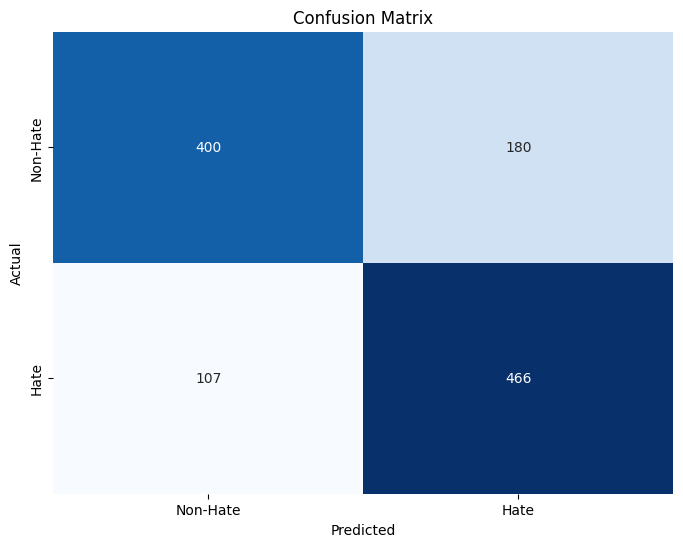

              precision    recall  f1-score   support

           0       0.79      0.69      0.74       580
           1       0.72      0.81      0.76       573

    accuracy                           0.75      1153
   macro avg       0.76      0.75      0.75      1153
weighted avg       0.76      0.75      0.75      1153



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.initializers import Constant

# Load GloVe embeddings into memory
embedding_dim = 100
embeddings_index = {}
glove_file = '/Users/manojkumarreddysodum/Desktop/glove.6B.100d.txt'
with open(glove_file, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Read the CSV file into a DataFrame
data = pd.read_csv('/Users/manojkumarreddysodum/Desktop/nlp proejct/final.csv')

# Preprocessing text
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'@[A-Za-z0-9]+', 'user', text)
    text = re.sub(r'&[^\s;]+;', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    tokens = nltk.word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text

data['preprocessed_tweet'] = data['tweet'].apply(preprocess_text)

# Tokenize the preprocessed text data and convert it into sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['preprocessed_tweet'])
X = tokenizer.texts_to_sequences(data['preprocessed_tweet'])
# Pad the sequences
max_sequence_length = 100  # Set a fixed sequence length
X = pad_sequences(X, maxlen=max_sequence_length, padding='post')
# Create embedding matrix
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, data['label'], test_size=0.2, random_state=42)

# Define the model
model = Sequential()
embedding_layer = Embedding(input_dim=vocab_size,
                            output_dim=embedding_dim,
                            embeddings_initializer=Constant(embedding_matrix),
                            trainable=False)
model.add(embedding_layer)

# Add Bidirectional LSTM layers
model.add(Bidirectional(LSTM(units=128, dropout=0.4, recurrent_dropout=0.4, return_sequences=True)))
model.add(Bidirectional(LSTM(units=64, dropout=0.4, recurrent_dropout=0.4)))

# Add additional layers
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.00001)

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, callbacks=[early_stopping, reduce_lr])

# Evaluate the model
y_pred = (model.predict(X_test) > 0.5).astype("int32")
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Non-Hate', 'Hate'], yticklabels=['Non-Hate', 'Hate'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
# Print classification report/
print(classification_report(y_test, y_pred))

